# Taller de segmentación de imágenes

La segementación semántica sobre imágenes consiste en, dada una imagen, determinar a que objeto de esa imagen corresponde cada pixel. Específicamente, consiste en un problema denso de clasificación de imágenes, es decir, en lugar de determinar a que clase corresponde una imagen completa, queremos determinar la clase de cada lugar de la imagen obteniendo así otras propiedades de los objetos como forma o tamaño.

![1](https://www.cityscapes-dataset.com/wordpress/wp-content/uploads/2015/07/koeln00.png)

# Arquitecturas neuronales para segmentación

La arquitectura de red más comunmente utilizada para realizar la tarea de segmentación sobre imágenes es la de los Autoencoder y existen multiples tipos y versiones. A continuación enumeramos algunos: 
- Autoencoders (AEs) 
- U-Net 
- V-Net - Se trabaja con volúmenes
- Autoencoder Variacional (VAE) 


# Autoencoder (AE)

El Autoencoder (AE) es la primera de las versiones, la más básica y de la que parten el resto de tipos de autoencoder. 

Consiste en una red neuronal, ya sea densa o convolucional, que presenta un cuello de botella. La función de este cuello de botella es reducir las dimensiones (comprimir) de los datos de entrada a un vector de pequeñas dimensiones que se conoce con el nombre de **huella latente**.

Se compone de dos partes principales:
- **Codificador:** Red neuronal que comprime los datos de entrada en la huella latente.
- **Decodificador:** Red neuronal que transforma la huella latente en un vector de grandes dimensiones que puede ser: los datos originales reconstruidos o una transformación de estos (Imagen de profundidas, flujo óptico, segmentación, etc)

![AE](https://raw.githubusercontent.com/SergioHdezG/TallerSegmentacionMUVA/master/imagenes/AE.png)

KRAMER, Mark A. Nonlinear principal component analysis using autoassociative neural networks. AIChE journal, 1991, vol. 37, no 2, p. 233-243.  https://doi.org/10.1002/aic.690370209

# Ejemplo práctico de Autoencoder
A continuación comenzamos la parte de implementación de este taller para aprender como construir un autoencoder en Keras.

## Recursos

En este notebook utilizamos la librería de cómputo Tensorflow (TF) y específicamente su módulo para deep learning Keras 

TensorFlow (TF2): https://www.tensorflow.org/

Keras: https://keras.io/

Como dataset se va a utilizar el Conference Video Segmentation Dataset (https://github.com/kuangzijian/Flow-Based-Video-Segmentation):
  
  * Data url: https://drive.google.com/file/d/13JKwoCaoSWQAjJ1YLVfV6AHvm8by09fP/view
  * Cuatro videos estilo conferencia con segmentación de las personas. 
  * Dataset creado semi artificialmente utilizando una pantalla verde de fondo.

Input: 

![Input Image](https://raw.githubusercontent.com/kuangzijian/Flow-Based-Video-Segmentation/master/readme_imgs/with_bg.jpg)

Ground truth: 

![Ground truth](https://raw.githubusercontent.com/kuangzijian/Flow-Based-Video-Segmentation/master/readme_imgs/ground_truth.jpg)



## Carga y preprocesado de datos

El primer paso para resolver cualquier problema de machine learning es cargar, visualizar y preprocesar el conjunto de datos que se va a utilizar.


In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras import backend as K

import os
#import cv2
import numpy as np
from matplotlib import image as plt_image
import matplotlib.pyplot as plt

2022-12-01 14:11:24.821538: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shernandez/.mujoco/mujoco210/bin:/usr/lib/nvidia
2022-12-01 14:11:24.821556: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


La siguiente celda solo es necesario ejecutarla si estás en google colab, si estás en binder omitela y omite el enlace al dataset.

El dataset se encuentra en: https://drive.google.com/file/d/1ChXfmym3HinaQ_3Bg37xQdUleaFb5F70/view?usp=sharing  

Añadelo a tu google drive

In [9]:
""" from google.colab import drive 
 drive.mount('/content/drive')"""

" from google.colab import drive \n drive.mount('/content/drive')"

El dataset se encuentra comprimido, hay que descomprimirlo.
En la siguiente instrucción escribe la ruta al archivo y la carpeta de destino

In [10]:
!unzip -u "datasets/ConferenceMinidataset.zip" -d "carpeta_destino"

Archive:  datasets/ConferenceMinidataset.zip


Cargamos los nombres de los ficheros en memoria y ordenamos los datos para que coincidan las imágenes de entrada con las máscaras de segmentación.

In [11]:
data_path = "carpeta_destino/ConferenceMinidataset"

training_in = os.listdir(os.path.join(data_path, "original_training"))
training_label = os.listdir(os.path.join(data_path, "ground_truth_training"))

# Ordenamos las imágenes por sequencia de video y por fotograma (original"seq"_"ft".jpg//gt"seq"_"ft".jpg)
training_in.sort(key= lambda x : (int(x.split("_")[0].split("l")[1]), int(x.split(".")[0].split("_")[1])))
training_label.sort(key= lambda x : (int(x.split("_")[0].split("t")[1]), int(x.split(".")[0].split("_")[1])))

print('Training size: ', len(training_in))
print(training_in[:10])
print(training_label[:10])

Training size:  1326
['original1_1.jpg', 'original1_2.jpg', 'original1_3.jpg', 'original1_4.jpg', 'original1_5.jpg', 'original1_6.jpg', 'original1_7.jpg', 'original1_8.jpg', 'original1_9.jpg', 'original1_10.jpg']
['gt1_1.jpg', 'gt1_2.jpg', 'gt1_3.jpg', 'gt1_4.jpg', 'gt1_5.jpg', 'gt1_6.jpg', 'gt1_7.jpg', 'gt1_8.jpg', 'gt1_9.jpg', 'gt1_10.jpg']


Cargamos los datos de entrenamiento en un numpy array.

En este ejemplo se cargan solo las 100 primeras imágenes.

In [12]:
x_train = [plt_image.imread(os.path.join(data_path, "original_training", name)) for name in training_in[:100]]
y_train = [plt_image.imread(os.path.join(data_path, "ground_truth_training", name)) for name in training_label[:100]]
print('Training size: ', len(x_train))


Training size:  100


En este ejemplo hemos preparado previamente los datos para que cada imagen tenga tamaño (128, 128). El dataset original contenía imágenes de dimensiones  (360, 640) que era necesario modificar por tres motivos:


1.   Para ajustarlos al tamaño de entrada que nos interesa en la red neuronal
2.   Para que al realizar convoluciones con stride=2 o Max Pooling no quede ninguna dimensión impar. Si se diese ese caso luego tendríamos problemas para recuperar el tamaño original a la salida del autoencoder.
3.   Para simplificar y acelerar el procesamiento a efectos prácticos de este taller.

La siguiente celda muestra un código de ejemplo para redimensionar las imágenes del dataset que no es necesario ejecutar.


In [13]:
"""import cv2
for i in range(len(x_train)):
    x_train[i] = cv2.resize(x_train[i], (128, 128))
    y_train[i] = cv2.resize(y_train[i], (128, 128))"""

'import cv2\nfor i in range(len(x_train)):\n    x_train[i] = cv2.resize(x_train[i], (128, 128))\n    y_train[i] = cv2.resize(y_train[i], (128, 128))'

Realizamos una visualización de los datos contenidos en el dataset.

Input image shape:  (128, 128, 3)
Label image shape:  (128, 128, 1)


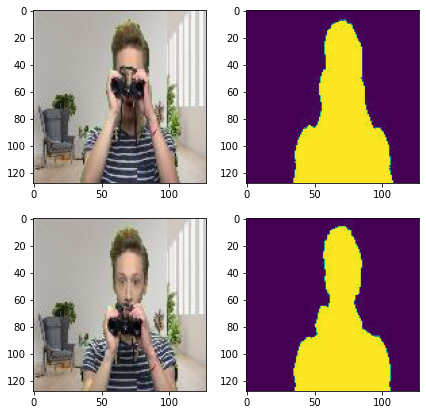

Train images range: : [ 0.0 ,  1.0 ]
Test images range: : [ 0.0 , 1.0 ]


In [60]:
n_img = np.random.randint(0, len(x_train))
img_in = x_train[n_img]
img_label = y_train[n_img]

print('Input image shape: ', img_in.shape)
print('Label image shape: ', img_label.shape)

plt.figure(figsize=(7,7))
plt.subplot(2, 2, 1)
plt.imshow(img_in)

plt.subplot(2, 2, 2)
plt.imshow(img_label)

n_img = np.random.randint(0, len(x_train))
img_in = x_train[n_img]
img_label = y_train[n_img]

plt.subplot(2, 2, 3)
plt.imshow(img_in)

plt.subplot(2, 2, 4)
plt.imshow(img_label)

plt.show()

print("Train images range: : [", np.amin(img_in), ", ", np.amax(img_in), "]")
print("Test images range: : [", np.amin(img_label), ",", np.amax(img_label), "]")

Como se puede observar en la celda anterior, los datos se encuentran en el rango de valores [0, 255]. Nos interesa normalizarlos al rango [0, 1] y convertirlos a tipo float32.

Posteriormente nos quedamos solo con uno de los tres canales de las imágenes segmentadas ya que se encuentran triplicados.

In [15]:
# Normalizamos los datos de entrada en rango [0, 1]
x_train = np.array(x_train, dtype=np.float32) / 255.
y_train = np.array(y_train, dtype=np.float32) / 255.

# Nos quedamos solo con el primer canal de las etiquetas
y_train = np.expand_dims(y_train[:, :, :, 0], axis=-1)

print('Input image shape: ', x_train[0].shape)
print('Label image shape: ', y_train[0].shape)

print("Train images range: : [", np.amin([x_train[0]]), ", ", np.amax(x_train[0]), "]")
print("Test images range: : [", np.amin(y_train[0]), ",", np.amax(y_train[0]), "]")

Input image shape:  (128, 128, 3)
Label image shape:  (128, 128, 1)
Train images range: : [ 0.0 ,  1.0 ]
Test images range: : [ 0.0 , 1.0 ]


Separamos un subconjunto de los datos para hacer validación.

In [23]:
# separamos un subconjunto de validación

val_split = 0.15
val_split = int(x_train.shape[0] * val_split)
val_idx = np.random.choice(x_train.shape[0], val_split, replace=False)  # Seleccionamos varios índices aleatorios
train_mask = np.array([False if i in val_idx else True for i in range(x_train.shape[0])])  # Creamos una máscara para seleccionar los datos de entrenamiento

x_val = x_train[val_idx]  # Seleccionamos datos de validacón
y_val = y_train[val_idx]

x_train = x_train[train_mask]  # Seleccionamos datos de entrenamiento
y_train = y_train[train_mask]

print('Train samples: ', x_train.shape[0])
print('Validation samples: ', x_val.shape[0])

Train samples:  85
Validation samples:  15


## Contruir el Autoencoder
Para la creación del Autoencoder se va a seguir la siguiente arquitectura:

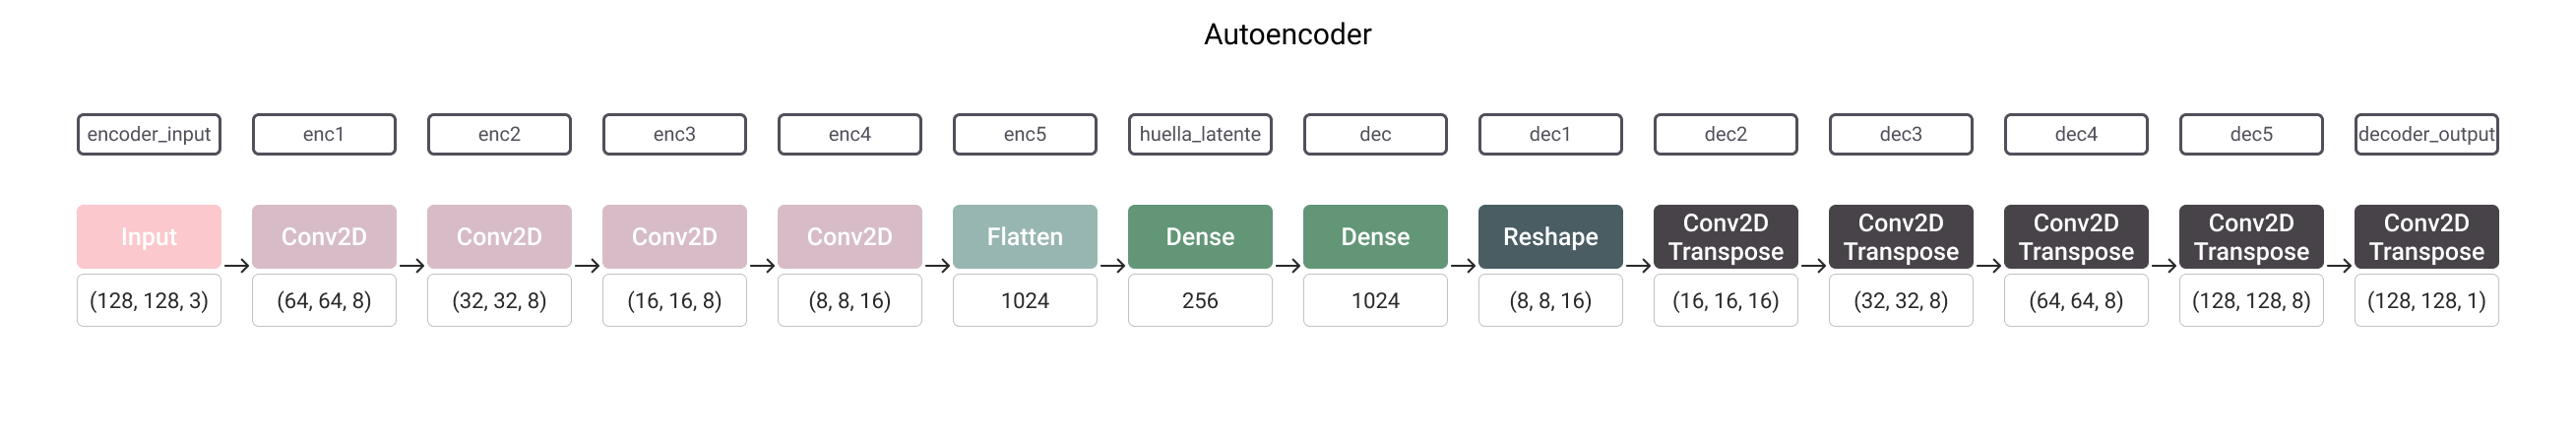

### Encoder:

Documentación funciones de activación: https://www.tensorflow.org/api_docs/python/tf/keras/activations

In [24]:
# Construir el codificador

input_shape = (128, 128, 3) # Definimos el tamaño de las imágenes de entrada
latent_dim = 256 # Tamaño de la huella latente

encoder_input = Input(shape=input_shape, name='encoder_input')  # Tensor de entrada

# Aplicamos convoluciones con xxxxx para reducir las dimensiones de los datos poco a poco
enc1 = Conv2D(filters=8,
            kernel_size= 3,
            activation= 'relu',
            strides= 2,
            padding='same')(encoder_input)

enc2 = Conv2D(filters=8,
            kernel_size=3,
            activation='relu',
            strides=2,
            padding='same')(enc1)

enc3 = Conv2D(filters=8,
            kernel_size=3,
            activation='relu',
            strides=2,
            padding='same')(enc2)

enc4 = Conv2D(filters=16,
            kernel_size=3,
            activation='relu',
            strides=2,
            padding='same')(enc3)

enc5 = Flatten()(enc4)

# Vector latente de dimensión latent_dim  
huella_latente = Dense(latent_dim, activation='linear', name='latent')(enc5)                      

### Decoder

A la hora de construir el decodificador hay que prestar especial atención a las dimensiones de los datos ya que queremos reconstruir una imagen del mismo tamaño que la original.

El tamaño de entrada de nuestra red es (128, 128, 3), en la salida de la última capa convoluconal el tamaño de los datos es  (8, 8, 16).y el tamaño de la huella latente es 256.

Al construir el decodificador hay que hacer el camino inverso. En este caso, convertiremos la huella latente en un vector de 1024 valores que daremos forma de imagen (8, 8, 16) con una capa Reshape. Una vez tenemos una imagen de la misma dimensión que la de la capa enc4 solo tenemos que deshacer los pasos utilizando convoluciones traspuestas. Finalmente, se obtiene una imagen de tamaño (128, 128, 8) que se procesará por una última capa con el número de filtros igual al número de canales de la imagen objetivo (en este caso uno) (128, 128, 1).

Una convolución transpuesta permite aplicar un kernel sobre una matriz y obtener una matriz resultante de tamaño mayor. [What is Transposed Convolutional Layer?](https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11)

![Convolución traspuesta](https://miro.medium.com/max/640/1*SpxCUPzNfb9C8TiAcrRr5A.gif)
![Convolución traspuesta stride=2](https://miro.medium.com/max/640/1*WaBzh5OkmD-9EBLy5aXiug.gif)


In [25]:
# Contruir el decodificador

enc4_shape = K.int_shape(enc4)  # Forma del vector enc4

# Esta capa densa transforma la huella latente en un vector con el mismo número de píxeles que la salida de la capa enc4
dec = Dense(enc4_shape[1] * enc4_shape[2] * enc4_shape[3], activation='relu')(huella_latente)

# Transformamos el vector dec y le damos forma de imagen
dec1 = Reshape((enc4_shape[1], enc4_shape[2], enc4_shape[3]))(dec)

# Aplicamos convoluciones traspuestas con xxx hasta alcanzar la forma (128, 128, 8)
dec2 = Conv2DTranspose(filters=16,
                    kernel_size=3,
                    activation='relu',
                    strides=2,
                    padding='same')(dec1)

dec3 = Conv2DTranspose(filters=8,
                    kernel_size=3,
                    activation='relu',
                    strides=2,
                    padding='same')(dec2)

dec4 = Conv2DTranspose(filters=8,
                    kernel_size=3,
                    activation='relu',
                    strides=2,
                    padding='same')(dec3)

dec5 = Conv2DTranspose(filters=8,
                    kernel_size=3,
                    activation='relu',
                    strides=2,
                    padding='same')(dec4)

# Transformamos el vector dec5 para que tenga el número de canales deseado
decoder_output = Conv2DTranspose(filters=1,
                      kernel_size=3,
                      activation='sigmoid',
                      padding='same',
                      name='decoder_output')(dec5)  # Activación xxxx para que las salidas estén en rango [0, 1]

Construimos y compilamos el modelo en keras

In [26]:
autoencoder =  tf.keras.models.Model(encoder_input, decoder_output, name='AE')

In [27]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=tf.keras.metrics.BinaryAccuracy(threshold=0.5))

autoencoder.summary()

Model: "AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 8)         224       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 8)         584       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 16)          1168      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
latent (Dense)               (None, 256)               262400   

## Entrenamiento



In [29]:
batch_size = 8
epochs = 50

autoencoder.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(x_val, y_val))

Epoch 1/50
11/11 [==============================] - 0s 20ms/step - loss: 0.2315 - binary_accuracy: 0.9038 - val_loss: 0.2343 - val_binary_accuracy: 0.9011
Epoch 2/50
11/11 [==============================] - 0s 19ms/step - loss: 0.2258 - binary_accuracy: 0.9047 - val_loss: 0.2263 - val_binary_accuracy: 0.9016
Epoch 3/50
11/11 [==============================] - 0s 19ms/step - loss: 0.2153 - binary_accuracy: 0.9057 - val_loss: 0.2118 - val_binary_accuracy: 0.9023
Epoch 4/50
11/11 [==============================] - 0s 20ms/step - loss: 0.1953 - binary_accuracy: 0.9062 - val_loss: 0.1847 - val_binary_accuracy: 0.9031
Epoch 5/50
11/11 [==============================] - 0s 18ms/step - loss: 0.1602 - binary_accuracy: 0.9072 - val_loss: 0.1458 - val_binary_accuracy: 0.9039
Epoch 6/50
11/11 [==============================] - 0s 19ms/step - loss: 0.1231 - binary_accuracy: 0.9076 - val_loss: 0.1238 - val_binary_accuracy: 0.9041
Epoch 7/50
11/11 [==============================] - 0s 19ms/step - los

Descomentar la siguiente celda para guardar los pesos del autoencoder.

In [30]:
# path = 'ruta a archivo'
# autoencoder.save_weights(path + ".h5")

Descomentar la siguiente celda para cargar los pesos del autencoder

In [32]:
# # path = 'ruta a archivo'

# # load weights into  model
# autoencoder.load_weights(path + ".h5")


# # # Si fuesemos a reentrenar necesitariamos compilar el modelo de nuevo
# # autoencoder.compile(optimizer='adam')

## Testing
En primer lugar vamos a pasar la red sobre el conjunto de test para ver si ha 
generalizado.

### Carga y preprocesado de datos de test
Para esto tenemos que cargar en primer lugar el conjunto de test.

In [33]:
testing_in = os.listdir(os.path.join(data_path, "original_testing"))
testing_label = os.listdir(os.path.join(data_path, "ground_truth_testing"))

# Ordenamos las imágenes por sequencia
testing_in.sort(key=lambda x: (int(x.split("_")[0].split("l")[1]), int(x.split(".")[0].split("_")[1])))
testing_label.sort(key=lambda x: (int(x.split("_")[0].split("t")[1]), int(x.split(".")[0].split("_")[1])))
x_test = [plt_image.imread(os.path.join(data_path, "original_testing", name)) for name in testing_in[:100]]
y_test = [plt_image.imread(os.path.join(data_path, "ground_truth_testing", name)) for name in testing_label[:100]]

Aplicaremos las mismas transformaciones que en el conjunto de entrenamiento, es decir, redimensionaremos las imágenes hasta el tamaño de entrada de la red y normalizaremos los datos. 

In [34]:
# Descomentar si fuese necesario redimensionar los datos
"""import cv2
for i in range(len(x_test)):
    x_test[i] = cv2.resize(x_test[i], (128, 128))
    y_test[i] = cv2.resize(y_test[i], (128, 128))"""

'import cv2\nfor i in range(len(x_test)):\n    x_test[i] = cv2.resize(x_test[i], (128, 128))\n    y_test[i] = cv2.resize(y_test[i], (128, 128))'

In [35]:
# Normalizamos los datos de entrada en rango [0, 1]
x_test = np.array(x_test) / 255.
y_test = np.array(y_test) / 255.
y_test = np.expand_dims(y_test[:, :, :, 1], axis=-1)

La función evaluate realiza un predict sobre cada entrada del conjunto de test y extrae las métricas que hayamos indicado al compilar el modelo.

In [36]:
autoencoder.evaluate(x_test, y_test, batch_size=batch_size)

13/13 [==============================] - 0s 6ms/step - loss: 2.8259 - binary_accuracy: 0.6465


[2.8259084224700928, 0.6464788913726807]

Por último, vamos a visualizar algunos de los resultados. 

La siguiente celda selecciona varias imágenes aleatorias y muestra su salida.

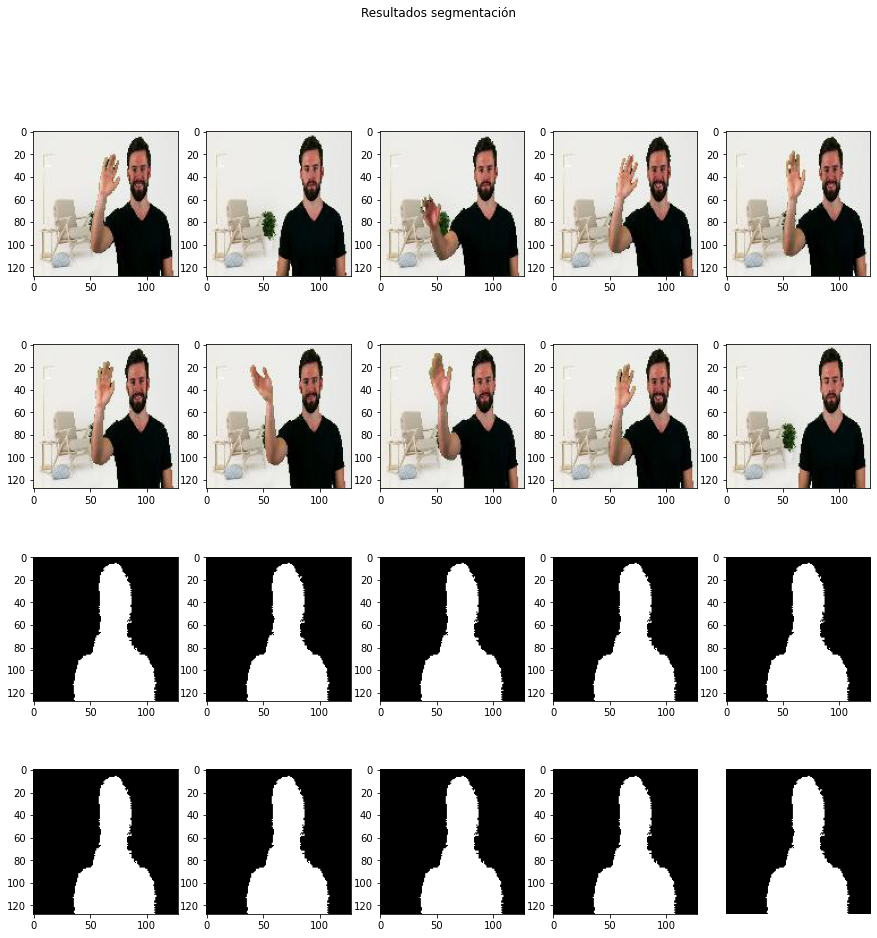

In [62]:
figsize = 5

# Selecionamos varias imágenes aleatorias del conjunto de test
examples_index = np.random.choice(x_test.shape[0], figsize*2)
examples = x_test[examples_index]

# Realizamos la predicción con el autoencoder
predictions = autoencoder.predict(examples)

# Ponemos a 1.0 los píxeles pertenecientes al primer plano y a 0. los pertenecientes al fondo
predictions[predictions > 0.5] = 1.0
predictions[predictions <= 0.5] = 0.0

predictions = np.squeeze(predictions, axis=-1)  # (w, h, 1) -> (w, h)

# Preparamos la figura de matplotlib
num_examples_to_generate = figsize*figsize

fig = plt.figure(figsize=(15,15))
fig.suptitle('Resultados segmentación')

for i in range(figsize*2):

    plt.subplot(4, figsize, i+1)
    plt.imshow(examples[i])
    plt.subplot(4, figsize, i + 1 + figsize*2)
    plt.imshow(predictions[i], cmap='gray')

plt.axis('off')
plt.show()

# U-Net

U-Net es una arquitectura basada en el autoencoder, completamente convolucional y con conexiones residuales.


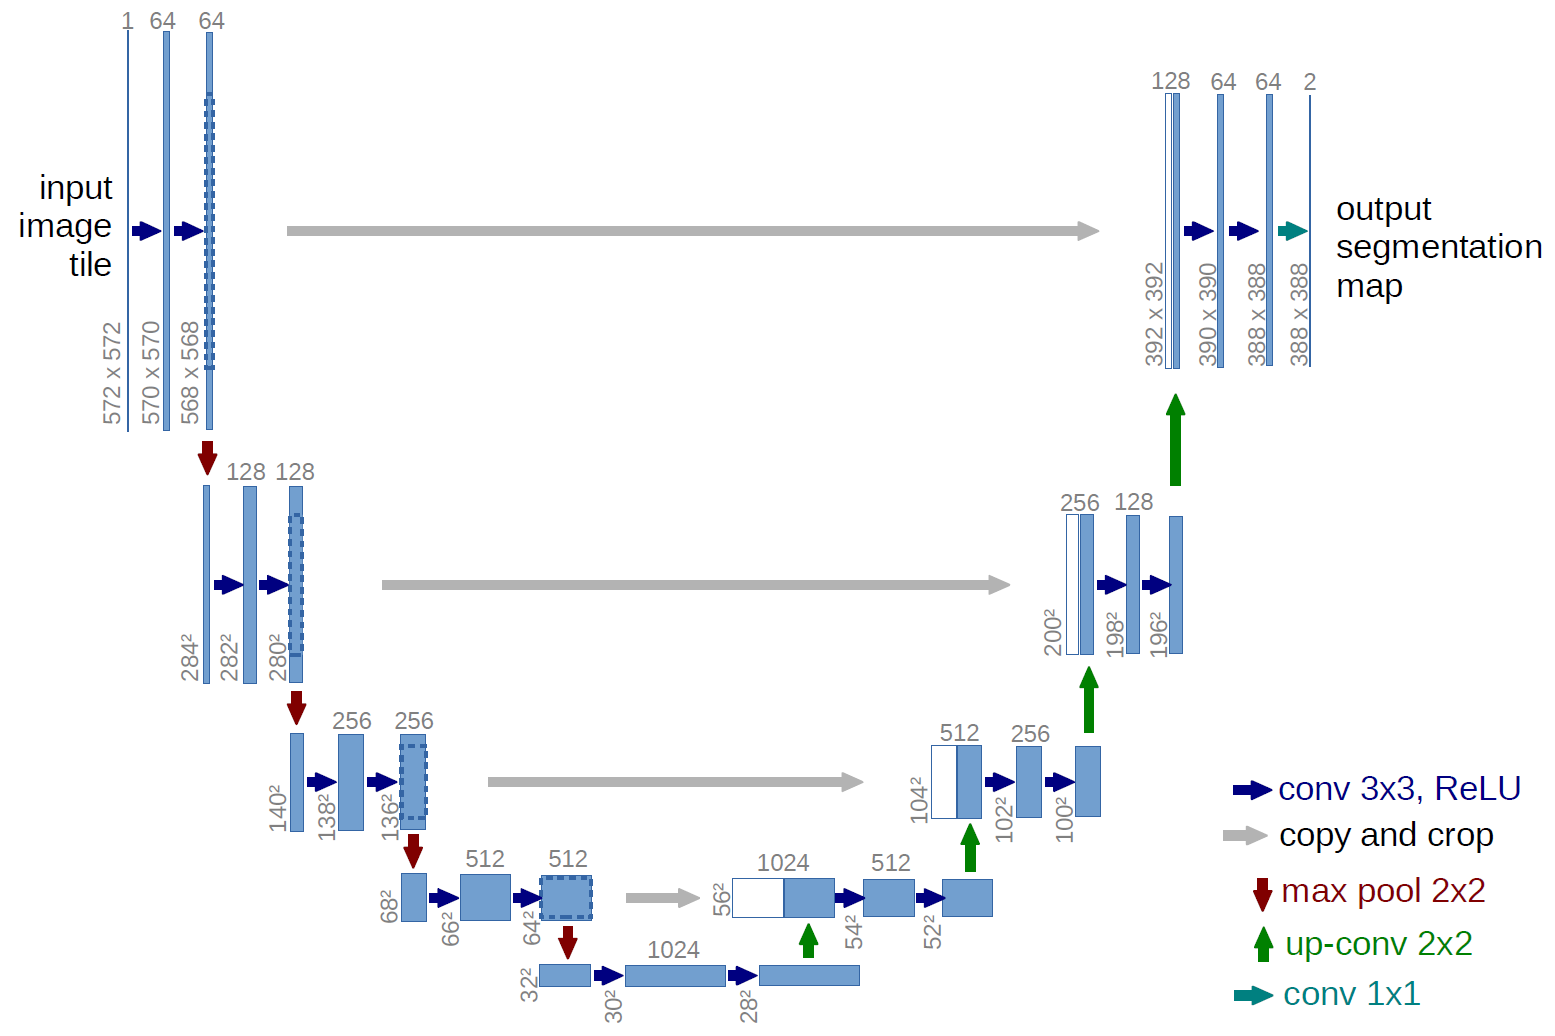


Ronneberger O., Fischer P., Brox T. (2015) U-Net: Convolutional Networks for Biomedical Image Segmentation. In: Navab N., Hornegger J., Wells W., Frangi A. (eds) Medical Image Computing and Computer-Assisted Intervention – MICCAI 2015. MICCAI 2015. Lecture Notes in Computer Science, vol 9351. Springer, Cham. https://doi.org/10.1007/978-3-319-24574-4_28

## Construcción de U-Net
A continuación vamos a ver como se construiría una U-Net.
En este caso vamos a dividir la red igualmente en dos partes: Codificador y Decodificador. La arquitectura a seguir se encuentra en el siguiente diagrama:

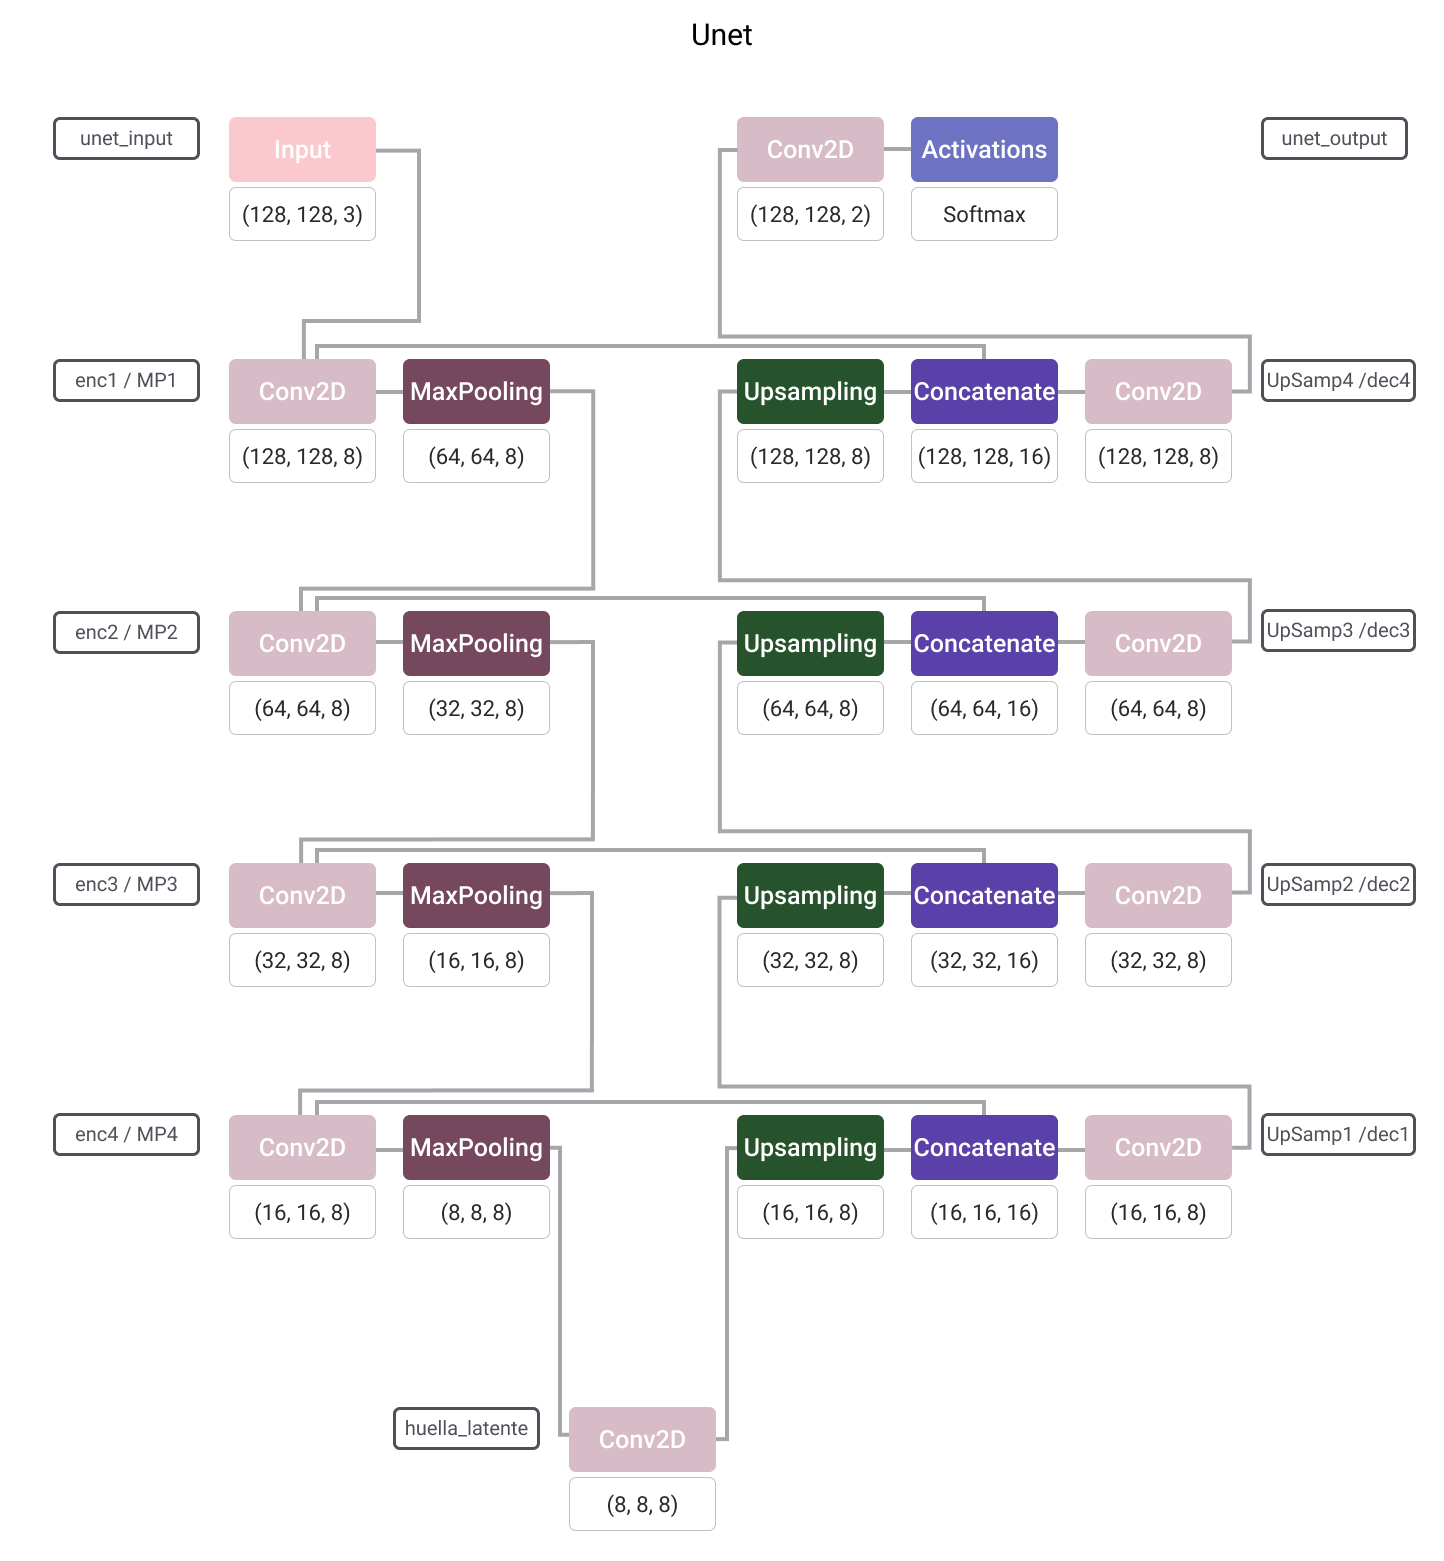

## Datos Categóricos
Para este ejemplo vamos a coger el mismo dataset que se ha utilizado en el ejemplo anterior y lo vamos a convertir en un problema categórico en lugar de un problema binario. 

Originalmente el problema de la segmentación del primer plano se ha planteado como un problema en el que los píxeles de una máscara con valor mayor que 0.5 (umbral que hemos elegido nosotros) pertenecen al primer plano y los los menores al fondo. 

Lo que queremos hacer ahora es convertirlo en un problema de clasificación en el que obtengamos dos máscaras, una para el primer plano y una para el fondo. Por lo tanto la máscara de segmentación que obtengamos como salida de la red estará formada por dos máscaras y tendrá forma (128, 128, 2) 

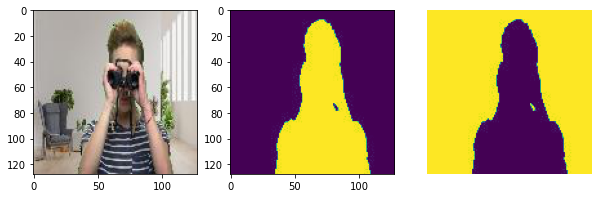

Train targets shape:  (85, 128, 128, 2)
Validation targets shape:  (15, 128, 128, 2)
Test targets shape:  (100, 128, 128, 2)


In [65]:
y_train_foreground = y_train[:]
y_train_background = np.abs(y_train[:] - 1)  # Invertimos la máscara para crear el fondo

fig = plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(x_train[0])

plt.subplot(1, 3, 2)
im_fg = np.squeeze(y_train_foreground[0], axis=-1)
plt.imshow(im_fg)

plt.subplot(1, 3, 3)
im_bg = np.squeeze(y_train_background[0], axis=-1)
plt.imshow(im_bg)

plt.axis('off')
plt.show()

y_train_unet = np.concatenate((y_train_background, y_train_foreground), axis=-1)
print('Train targets shape: ', y_train_unet.shape)

y_val_foreground = y_val[:]
y_val_background = np.abs(y_val[:] - 1)

y_val_unet = np.concatenate((y_val_foreground, y_val_background), axis=-1)
print('Validation targets shape: ', y_val_unet.shape)

y_test_foreground = y_test[:]
y_test_background = np.abs(y_test[:] - 1)

y_test_unet = np.concatenate((y_test_background, y_test_foreground), axis=-1)
print('Test targets shape: ',y_test_unet.shape)

### Encoder

In [40]:
# Construir el codificador de U-Net

input_shape = (128, 128, 3)  # Definimos el tamaño de las imágenes de entrada

unet_input = Input(shape=input_shape, name='encoder_input')  # Tensor de entrada

# En este caso aplicamos MaxPooling para reducir las dimensiones de los datos poco a poco
enc1 = Conv2D(filters=8,
            kernel_size=3,
            activation='relu',
            strides=1,
            padding='same')(unet_input)

maxpool1 = MaxPooling2D((2, 2))(enc1)

enc2 = Conv2D(filters=8,
            kernel_size=3,
            activation='relu',
            strides=1,
            padding='same')(maxpool1)

maxpool2 = MaxPooling2D((2, 2))(enc2)

enc3 = Conv2D(filters=8,
            kernel_size=3,
            activation='relu',
            strides=1,
            padding='same')(maxpool2)

maxpool3 = MaxPooling2D((2, 2))(enc3)

enc4 = Conv2D(filters=8,
            kernel_size=3,
            activation='relu',
            strides=1,
            padding='same')(maxpool3)

maxpool4 = MaxPooling2D((2, 2))(enc4)

huella_latente = Conv2D(filters=8,
                  kernel_size=3,
                  activation='relu',
                  strides=1,
                  padding='same')(maxpool4)

### Decoder

En este caso el decodificador ha de reconstruir una imagen con tamaño (128, 128, 2) que es la dimensión del ground thruth. Además, en U-Net se crean conexiones residuales entre las capas del mismo nivel del codificador y el decodificador mediante una concatenación. 

Es importante tener en cuenta que en este caso no se utilizan convoluciones traspuestas y por lo tanto, usar un stride=2 no va a aumentar el tamaño de los vectores. Para realizar este paso, en el codificador se ha utilizado Max Pooling y en el decodificador se tendrá que usar una operación inversa que es Up Samplig.

In [44]:
# Contruir el decodificador

# Aplicamos convoluciones traspuestas con stride=2 hasta alcanzar la forma (128, 128, 8)
UpSamp1 = UpSampling2D((2, 2))(huella_latente)
UpSamp1 = Concatenate()([UpSamp1, enc4])

dec1 = Conv2D(filters=8,
              kernel_size=3,
              activation='relu',
              strides=1,
              padding='same')(UpSamp1)

UpSamp2 = UpSampling2D((2, 2))(dec1)
UpSamp2 = Concatenate()([UpSamp2, enc3])

dec2 = Conv2D(filters=8,
              kernel_size=3,
              activation='relu',
              strides=1,
              padding='same')(UpSamp2)

UpSamp3 = UpSampling2D((2, 2))(dec2)
UpSamp3 = Concatenate()([UpSamp3, enc2])

dec3 = Conv2D(filters=8,
              kernel_size=3,
              activation='relu',
              strides=1,
              padding='same')(UpSamp3)

UpSamp4 = UpSampling2D((2, 2))(dec3)
UpSamp4 = Concatenate()([UpSamp4, enc1])

dec4 = Conv2D(filters=8,
              kernel_size=3,
              activation='relu',
              strides=1,
              padding='same')(UpSamp4)

# Transformamos el vector dec4 para que tenga el número de canales deseado
unet_output = Conv2DTranspose(filters=2,
                              kernel_size=1,
                              activation='linear',
                              padding='same',
                              name='decoder_output')(dec4)

unet_output = tf.keras.activations.softmax(unet_output, axis=-1)

In [45]:
unet =  tf.keras.models.Model(unet_input, unet_output, name='U-Net')

In [46]:
# unet.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4),
#                     loss=tf.keras.losses.BinaryCrossentropy(),
#                     metrics=tf.keras.metrics.BinaryAccuracy(threshold=0.5))
unet.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                    loss=tf.keras.losses.CategoricalCrossentropy(),
                    metrics=tf.keras.metrics.CategoricalAccuracy())

unet.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 128, 128, 8)  224         encoder_input[0][0]              
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 8)    0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 64, 64, 8)    584         max_pooling2d[0][0]              
______________________________________________________________________________________________

/home/shernandez/anaconda3/envs/tf26/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## Entrenar U-Net

In [47]:
batch_size = 8
epochs = 50

unet.fit(x_train, y_train_unet, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(x_val, y_val_unet))

Epoch 1/50
11/11 [==============================] - 1s 72ms/step - loss: 0.6491 - categorical_accuracy: 0.6983 - val_loss: 0.7619 - val_categorical_accuracy: 0.3033
Epoch 2/50
11/11 [==============================] - 1s 60ms/step - loss: 0.6305 - categorical_accuracy: 0.7007 - val_loss: 0.7932 - val_categorical_accuracy: 0.2985
Epoch 3/50
11/11 [==============================] - 1s 60ms/step - loss: 0.6125 - categorical_accuracy: 0.7012 - val_loss: 0.8265 - val_categorical_accuracy: 0.2990
Epoch 4/50
11/11 [==============================] - 1s 60ms/step - loss: 0.5991 - categorical_accuracy: 0.7011 - val_loss: 0.8491 - val_categorical_accuracy: 0.2989
Epoch 5/50
11/11 [==============================] - 1s 60ms/step - loss: 0.5903 - categorical_accuracy: 0.7011 - val_loss: 0.8712 - val_categorical_accuracy: 0.2989
Epoch 6/50
11/11 [==============================] - 1s 59ms/step - loss: 0.5810 - categorical_accuracy: 0.7013 - val_loss: 0.8941 - val_categorical_accuracy: 0.2984
Epoch 7/50

## Testing U-Net
Vamos a pasar la red sobre el conjunto de test para ver si ha 
generalizado.

La función evaluate realiza un predict sobre cada entrada del conjunto de test y extrae las métricas que hayamos indicado al compilar el modelo.

In [48]:
unet.evaluate(x_test, y_test_unet, batch_size=batch_size)

13/13 [==============================] - 0s 14ms/step - loss: 0.5293 - categorical_accuracy: 0.8741


[0.5293384194374084, 0.8740631341934204]

Por último, vamos a visualizar algunos de los resultados. 

La siguiente celda selecciona varias imágenes aleatorias y muestra su salida.

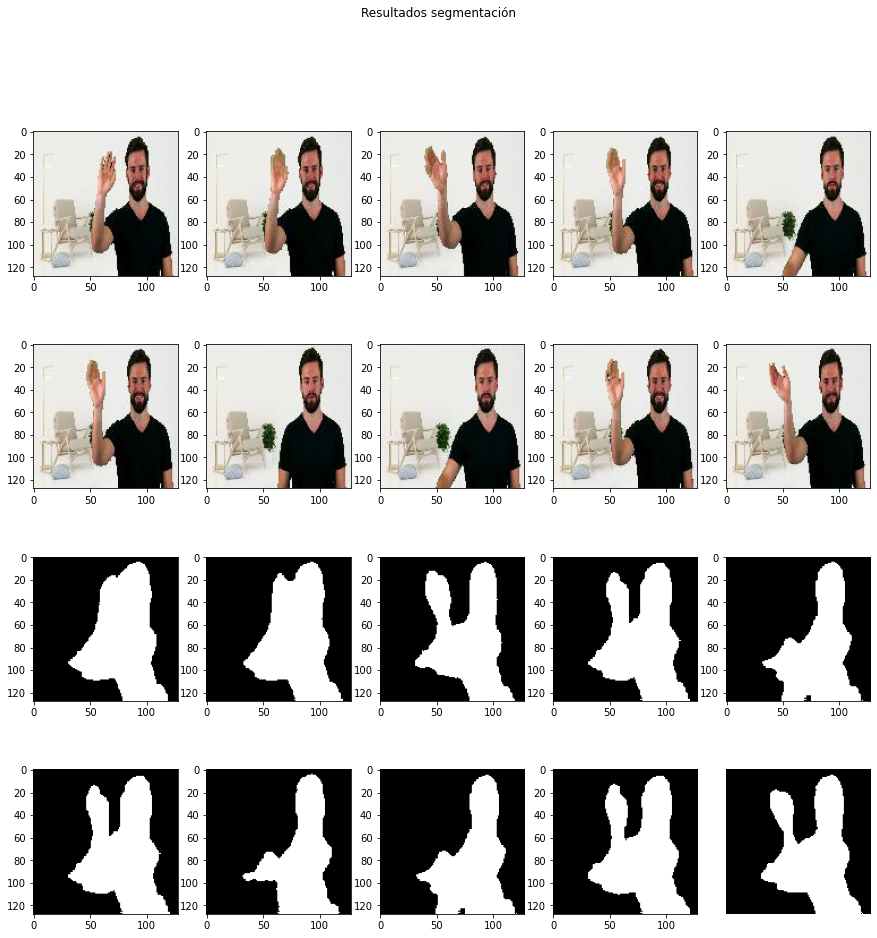

In [66]:
# Selecionamos varias imágenes aleatorias del conjunto de test
examples_index = np.random.choice(x_test.shape[0], figsize*2)
examples = x_test[examples_index]

# Realizamos la predicción con el autoencoder
predictions = unet.predict(examples)

predictions = np.argmax(predictions, axis=-1)  # (n, 128, 128)

# Preparamos la figura de matplotlib
figsize = 5
num_examples_to_generate = figsize*figsize

fig = plt.figure(figsize=(15, 15))
fig.suptitle('Resultados segmentación')

for i in range(figsize*2):

    plt.subplot(4, figsize, i+1)
    plt.imshow(examples[i])
    plt.subplot(4, figsize, i + 1 + figsize*2)
    plt.imshow(predictions[i], cmap='gray')

plt.axis('off')
plt.show()

A continuación vamos a realizar una visualización de los mapas de probabilidad generado para cada máscara

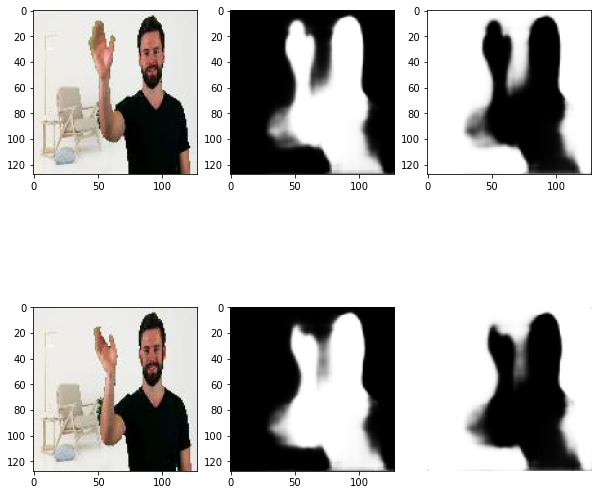

In [67]:
# Selecionamos varias imágenes aleatorias del conjunto de test
examples_index = np.random.choice(x_test.shape[0], 2)
examples = x_test[examples_index]

# Realizamos la predicción con el autoencoder
predictions = unet.predict(examples)

predictions_bg = predictions[:, :, :, 0]
predictions_fg = predictions[:, :, :, 1]

# Preparamos la figura de matplotlib
num_examples_to_generate = figsize*figsize

fig = plt.figure(figsize=(10, 10))

plt.subplot(2, 3, 1)  #, title='Original')
plt.imshow(examples[0])

plt.subplot(2, 3, 2)
plt.imshow(predictions_fg[0], cmap='gray')

plt.subplot(2, 3, 3)
plt.imshow(predictions_bg[0], cmap='gray')

plt.subplot(2, 3, 4)
plt.imshow(examples[1])

plt.subplot(2, 3, 5)
plt.imshow(predictions_fg[1], cmap='gray')

plt.subplot(2, 3, 6)
plt.imshow(predictions_bg[1], cmap='gray')

plt.axis('off')
plt.show()

# Experimentos


*   ¿Se puede implementar una Unet utilizando convoluciones traspuestas para decodificar la huella latente?
*   Si en la salida de la red tenemos una máscara con valores entre 0 y 1 por cada clase, ¿cuándo consideramos que ese píxel pertenece a la clase del objeto que estamos segmentando?





# Otros recursos
A continuación os dejamos algunos recursos con información sobre plataformas de cómputo para Deep Learning como Tensorflow, keras y pytorch. 

También teneis algunos enlaces a datasets de segmentación pequeños que se pueden utilizar para talleres y pruebas y a sitios web donde podeis encontrar otros datasets.

## Recursos y tutoriales

TensorFlow (TF2): https://www.tensorflow.org/

Keras: https://keras.io/

*   Tutoriales TF2: https://www.tensorflow.org/tutorials
  *   Segmentación: https://www.tensorflow.org/tutorials/images/segmentation
  *   Autoencoder variacional: https://www.tensorflow.org/tutorials/generative/cvae
*   Tutoriales keras: https://keras.io/examples/
  *   Segmentación con U-Net: https://keras.io/examples/vision/oxford_pets_image_segmentation/
  *   Autoencoder para denoising: https://keras.io/examples/vision/autoencoder/
  *   Segementación con DeepLabV3+: https://keras.io/examples/vision/deeplabv3_plus/


## Datasets

* Datasets interesantes para realizar pequeñas pruebas
  * ConferenceVideoSegmentationDataset: https://github.com/kuangzijian/Flow-Based-Video-Segmentation 
    * Data url: https://drive.google.com/file/d/13JKwoCaoSWQAjJ1YLVfV6AHvm8by09fP/view
    * Cuatro videos estilo conferencia con segmentaciones de las personas. 
    * Dataset creado semi artificialmente utilizando una pantalla verde de fondo

  * The Oxford-IIIT Pet Dataset: https://www.robots.ox.ac.uk/~vgg/data/pets/
    * 36 tipos de máscotas segmentadas con 200 imágenes por tipo
    * Anotaciones de backgroud, edges y foreground.

* Colecciones de datasets: 
  * Papers with Code: https://paperswithcode.com/datasets?q=segmentation&v=lst&o=match&page=1
  * Kaggle: https://www.kaggle.com/datasets
  * UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/index.php
  * Google Dataset Search: https://datasetsearch.research.google.com/
  * Visual Data: https://visualdata.io/discovery